<a href="https://colab.research.google.com/github/nagaichsid/causalML/blob/master/CausalEffectsLoanDefaults_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Causal ML Final Project Submission
For Dr. Ness' Causal ML Workshop in Summer 2022

Group: Shefali Khatri and Sid Nagaich

## Evaluating Causal Effects on Loan Default Data

For our project we are using Loan Prediction data from kaggle that contains 252,000 observations and 11 variables which include:

* Income 
* Age
* Experience
* Marital Status
* House Ownership
* Car Ownership
* Profession
* City
* State
* Years in Current Job
* Years in Current House

The dataset can be found at https://www.kaggle.com/datasets/subhamjain/loan-prediction-based-on-customer-behavior?select=Training+Data.csv. The goal of our project is to evaluate how income, home ownership, and car ownership may be causally related to whether an individual defaults on a loan and conversely, how defaulting on a loan may be causally related to home or car ownership. We will conduct this analysis by estimating the average treatment effect (ATE) and conditional average treatment effect (CATE) to evaluate the causal relationship between loan defaults and home ownership, car ownership, and income. Our first step in evaluating the impact of these factors is to theorize how these factors may be related to each other and develop Causal DAGs that reflect our domain knowledge. Below we propose a Causal DAG that represents our assumptions about how income is causally related to loan defaults. We also evaluated whether a history of loan default is causally related to the lack of home or car ownership by income to evaluate how individuals in different income groups may be affected differently by loan defaults. Before we construct the Causal DAG, we import the data and perform data cleaning.

# Load Dataset Using Kaggle API

In [ ]:
%%capture
!pip install kaggle
!pip install pgmpy
!pip install pygraphviz
!pip install dowhy

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json 
import os
import networkx as nx
import graphviz
from IPython.display import Image, display
from dowhy import CausalModel
import dowhy.gcm as gcm
from pathlib import Path
from pgmpy.base.DAG import DAG

import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# your api key
api_key = {
'username':"neusnagaich" ,
'key':"5eca26127ba98bcfacb91b6d9716df50"
}

# uses pathlib Path
kaggle_path = Path('/root/.kaggle')
os.makedirs(kaggle_path, exist_ok=True)

# opens file and dumps python dict to json object 
with open (kaggle_path/'kaggle.json', 'w') as handl:
    json.dump(api_key,handl)

os.chmod(kaggle_path/'kaggle.json', 600)  

In [ ]:
!kaggle datasets download subhamjain/loan-prediction-based-on-customer-behavior

  0% 0.00/5.15M [00:00<?, ?B/s]
100% 5.15M/5.15M [00:00<00:00, 91.1MB/s]


In [ ]:
!unzip loan-prediction-based-on-customer-behavior.zip

Archive:  loan-prediction-based-on-customer-behavior.zip
  inflating: Sample Prediction Dataset.csv  
  inflating: Test Data.csv           
  inflating: Training Data.csv       


# Inspecting the Data

In [ ]:
## Import Data
df = pd.read_csv('Training Data.csv')
df.head()

,Id,Income,Age,Experience,Married/Single,House_Ownership,Car_Ownership,Profession,CITY,STATE,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,Risk_Flag
0,1,1303834,23,3,single,rented,no,Mechanical_engineer,Rewa,Madhya_Pradesh,3,13,0
1,2,7574516,40,10,single,rented,no,Software_Developer,Parbhani,Maharashtra,9,13,0
2,3,3991815,66,4,married,rented,no,Technical_writer,Alappuzha,Kerala,4,10,0
3,4,6256451,41,2,single,rented,yes,Software_Developer,Bhubaneswar,Odisha,2,12,1
4,5,5768871,47,11,single,rented,no,Civil_servant,Tiruchirappalli[10],Tamil_Nadu,3,14,1


In [ ]:
## Inspect Column Values
df.value_counts("Married/Single")

Married/Single
single     226272
married     25728
dtype: int64

The home ownership column has 3 categories and therefore would be converted into 3 classes, by default. To convert this into a binary variable, rented ownership status is changed to no ownership.

In [ ]:
df.value_counts("House_Ownership")

House_Ownership
rented          231898
owned            12918
norent_noown      7184
dtype: int64

In [ ]:
# Fix Ownership column
def change_ownership(ownership_status):
  if ownership_status == "rented":
    return "norent_noown"
  return ownership_status

df['House_Ownership'] = df['House_Ownership'].apply(change_ownership)

df.value_counts("House_Ownership")

House_Ownership
norent_noown    239082
owned            12918
dtype: int64

In [ ]:
df.value_counts("Car_Ownership")

Car_Ownership
no     176000
yes     76000
dtype: int64

In [ ]:
df.value_counts("CITY")

CITY
Vijayanagaram       1259
Bhopal              1208
Bulandshahr         1185
Saharsa[29]         1180
Vijayawada          1172
                    ... 
Ujjain               486
Warangal[11][12]     459
Bettiah[33]          457
Katni                448
Karaikudi            431
Length: 317, dtype: int64

In [ ]:
# CLEANING DATA
def cleanData(df):
  # grab headers
  headers = [h for h in df.columns]

  # these columns contain numeric data
  n_cols = df[headers].select_dtypes(include=np.number).columns.tolist()
  print("\nnumeric columns: ", n_cols)

  # these columns contain categorical data
  c_cols = df[headers].select_dtypes('object').columns.tolist()
  print("\ncategorical columns: ", c_cols)

  # encode categorical data using pandas 
  df[c_cols] = df[c_cols].astype('category')
  df[c_cols] = df[c_cols].apply(lambda x: x.cat.codes)

  # replace missing data with the average of the column
  df = df.fillna(df.mean())

  # return df
  return df

# clean data
cleanData(df)
# show cleaned data
df


numeric columns:  ['Id', 'Income', 'Age', 'Experience', 'CURRENT_JOB_YRS', 'CURRENT_HOUSE_YRS', 'Risk_Flag']

categorical columns:  ['Married/Single', 'House_Ownership', 'Car_Ownership', 'Profession', 'CITY', 'STATE']


,Id,Income,Age,Experience,Married/Single,House_Ownership,Car_Ownership,Profession,CITY,STATE,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,Risk_Flag
0,1,1303834,23,3,1,2,0,33,251,13,3,13,0
1,2,7574516,40,10,1,2,0,43,227,14,9,13,0
2,3,3991815,66,4,0,2,0,47,8,12,4,10,0
3,4,6256451,41,2,1,2,1,43,54,17,2,12,1
4,5,5768871,47,11,1,2,0,11,296,22,3,14,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
251995,251996,8154883,43,13,1,2,0,45,162,28,6,11,0
251996,251997,2843572,26,10,1,2,0,3,251,13,6,11,0
251997,251998,4522448,46,7,1,2,0,17,144,14,7,12,0
251998,251999,6507128,45,0,1,2,0,27,233,18,0,10,0


# Analysis of Income on Loan Default

## Step 1: Model Causal Mechanism

In [ ]:
# Build the causal DAG.
dot = graphviz.Digraph()

dot.node('Age', 'Age')
dot.node('Married/Single', 'Married/Single')
dot.node('House_Ownership', 'House_Ownership')
dot.node('CURRENT_JOB_YRS', 'CURRENT_JOB_YRS')
dot.node('Experience', 'Experience')
dot.node('Income', 'Income')
dot.node('House_Ownership', 'House_Ownership')
dot.node('Profession', 'Profession')
dot.node('CITY', 'CITY')
dot.node('Car_Ownership', 'Car_Ownership')
dot.node('CURRENT_HOUSE_YRS', 'CURRENT_HOUSE_YRS')
dot.node('Risk_Flag', 'Risk_Flag')
dot.node('Latent Variables', 'Latent Variables')

dot.edge('Latent Variables', 'CITY')
dot.edge('Age','Married/Single')
dot.edge('Married/Single','House_Ownership')
dot.edge('Age','CURRENT_JOB_YRS')
dot.edge('CURRENT_JOB_YRS','Experience')
dot.edge('Experience','Income')
dot.edge('Income','House_Ownership')
dot.edge('Profession','Income')
dot.edge('CITY', 'Profession')
dot.edge('CITY', 'Car_Ownership')
dot.edge('CITY', 'House_Ownership')
dot.edge('Income', 'Car_Ownership')
dot.edge('House_Ownership', 'CURRENT_HOUSE_YRS')
dot.edge('Income', 'Risk_Flag')
dot.edge('CITY', 'Risk_Flag')
    
print(dot.source)

digraph {
	Age [label=Age]
	"Married/Single" [label="Married/Single"]
	House_Ownership [label=House_Ownership]
	CURRENT_JOB_YRS [label=CURRENT_JOB_YRS]
	Experience [label=Experience]
	Income [label=Income]
	House_Ownership [label=House_Ownership]
	Profession [label=Profession]
	CITY [label=CITY]
	Car_Ownership [label=Car_Ownership]
	CURRENT_HOUSE_YRS [label=CURRENT_HOUSE_YRS]
	Risk_Flag [label=Risk_Flag]
	"Latent Variables" [label="Latent Variables"]
	"Latent Variables" -> CITY
	Age -> "Married/Single"
	"Married/Single" -> House_Ownership
	Age -> CURRENT_JOB_YRS
	CURRENT_JOB_YRS -> Experience
	Experience -> Income
	Income -> House_Ownership
	Profession -> Income
	CITY -> Profession
	CITY -> Car_Ownership
	CITY -> House_Ownership
	Income -> Car_Ownership
	House_Ownership -> CURRENT_HOUSE_YRS
	Income -> Risk_Flag
	CITY -> Risk_Flag
}


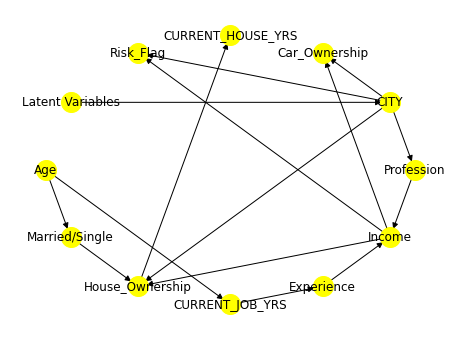

In [ ]:
# I. Create a causal model from the data and domain knowledge.
model = CausalModel(
    data=df,
    graph = dot.source.replace("\t", " ").replace("\n", ' '),
    treatment=['Income'],
    outcome=["Risk_Flag"],
    common_causes=["CITY"],
    # Should age be the instrument as it is the direct cause of marital status?
    # How do we account for the mediator of years in current house?
    instruments =['Profession', 'Experience'])
model.view_model()

In the above Causal DAG, we construct a graph of Income (the Treatment), Risk_Flag (the outcome), Profession and Experience (instrumental variables), and City (common causes). Although, city may or may not be causally related to loan default, there is various research that suggests some cities are more susceptible to experiencing high loan defaults relative to others. Many external factors that make up a city can lead to higher loan defaults. To account for those factors we have added a set of latent variables that are causally related to city. In our DAG, we also assume the following causal relationships:

* Age -> Married/Single
* Married/Single -> House_Ownership
* Age -> CURRENT_JOB_YRS
* CURRENT_JOB_YRS -> Experience
* Experience -> Income
* Income -> House_Ownership
* Profession -> Income
* CITY -> Profession
* CITY -> Car_Ownership
* CITY -> House_Ownership
* Income -> Car_Ownership
* House_Ownership -> CURRENT_HOUSE_YRS
* Income -> Risk_Flag
* CITY -> Risk_Flag

## Step 2: Identify the Target Estimand

In [ ]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
    d                                       
─────────(Expectation(Risk_Flag|Profession))
d[Income]                                   
Estimand assumption 1, Unconfoundedness: If U→{Income} and U→Risk_Flag then P(Risk_Flag|Income,Profession,U) = P(Risk_Flag|Income,Profession)

### Estimand : 2
Estimand name: iv
Estimand expression:
Expectation(Derivative(Risk_Flag, [Experience])*Derivative([Income], [Experien
ce])**(-1))
Estimand assumption 1, As-if-random: If U→→Risk_Flag then ¬(U →→{Experience})
Estimand assumption 2, Exclusion: If we remove {Experience}→{Income}, then ¬({Experience}→Risk_Flag)

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



As 2 estimands were identified given the data and the causal DAG, it suggests that a causal effect can be estimated. The first estimand indicates that we can use the Backdoor criterion to estimate the causal effect. The Backdoor criterion suggest that if all common causes are identified, then they can be conditioned on to estimate the effect. While other common causes may exist that are not present in the data such as credit rating, we are making a simplification for our project. The second estimand is Instrumental Variable identification. This method relies on splitting up the effect of the instrument on the treatment and the treatment and the action to measure the effect of the treatment on the outcome. The second estimand suggests we can use the instrumental variable, experience, to estimate the causal effect. The third estimand is based on the frontdoor criterion and allows us to control for any unobserved confounders if we have a mediator. As there is no mediator between income and risk of default, an estimand through the frontdoor criterion cannot be found.

## Step 3: Estimate the Causal Effect Using Statistical Estimators

1. Linear Regression

In this approach, a linear regression model is fit over the treatment and the common causes to target the backdoor estimand. The resulting coefficient of our treatment represents the estimate of the causal effect. As the Causal effect estimate is within the 95% confidence interval, we cannot reject the null hypothesis that the true value of the coefficient is 0. Additionally, our results seem to support this.

In [ ]:
causal_estimate_reg = model.estimate_effect(identified_estimand,
        method_name="backdoor.linear_regression",
        confidence_intervals=True)

print(causal_estimate_reg)
print("The causal effect estimate is " + str(round(causal_estimate_reg.value, 4)))

linear_regression
{'control_value': 0, 'treatment_value': 1, 'test_significance': None, 'evaluate_effect_strength': False, 'confidence_intervals': True, 'target_units': 'ate', 'effect_modifiers': []}
*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
    d                                       
─────────(Expectation(Risk_Flag|Profession))
d[Income]                                   
Estimand assumption 1, Unconfoundedness: If U→{Income} and U→Risk_Flag then P(Risk_Flag|Income,Profession,U) = P(Risk_Flag|Income,Profession)

## Realized estimand
b: Risk_Flag~Income+Profession
Target units: ate

## Estimate
Mean value: -3.5232111672556243e-10
95.0% confidence interval: [[-7.97834566e-10  9.31923282e-11]]

The causal effect estimate is -0.0


2. Propensity Score Stratification

Propensity score stratification was attempted, but resulted in an error as it is only applicable to binary treatments.

In [ ]:
causal_estimate_strat = model.estimate_effect(identified_estimand,
                                              method_name="backdoor.propensity_score_stratification",
                                              target_units="ate",
                                              confidence_intervals=True)
print(causal_estimate_strat)
print("The causal effect estimate is " + str(round(causal_estimate_strat.value, 4)))

ERROR:dowhy.causal_estimator:Propensity score methods are applicable only for binary treatments


propensity_score_stratification


Exception: ignored

3. Propensity Score Weighting

Similarly, propensity score weighting was attempted, but was not applicable as the treatment variable is not binary.

In [ ]:
causal_estimate_ipw = model.estimate_effect(identified_estimand,
                                            method_name="backdoor.propensity_score_weighting",
                                            target_units = "ate",
                                            method_params={"weighting_scheme":"ips_weight"},
                                            confidence_intervals=True)
print(causal_estimate_ipw)
print("The causal effect estimate is " + str(round(causal_estimate_ipw.value, 4)))

ERROR:dowhy.causal_estimator:Propensity score methods are applicable only for binary treatments


propensity_score_weighting


Exception: ignored

4. Distance Matching

Distance Matching was also attempted but resulted in an error as it is only applicable for binary treatment.

In [ ]:
causal_estimate_dmatch = model.estimate_effect(identified_estimand,
                                              method_name="backdoor.distance_matching",
                                              target_units="ate",
                                              method_params={'distance_metric':"minkowski", 'p':2},
                                              confidence_intervals = True)
print(causal_estimate_dmatch)
print("The causal effect estimate is " + str(round(causal_estimate_dmatch.value),4))

ERROR:dowhy.causal_estimator:Distance Matching method is applicable only for binary treatments


distance_matching


Exception: ignored

5. Propensity Score Matching

Propensity Score Matching was also attempted, but was only relevant for binary treatments.

In [ ]:
causal_estimate_match = model.estimate_effect(identified_estimand,
                                              method_name="backdoor.propensity_score_matching",
                                              target_units="atc")
print(causal_estimate_match)
print("Causal Estimate is " + str(causal_estimate_match.value))

ERROR:dowhy.causal_estimator:Propensity score methods are applicable only for binary treatments


propensity_score_matching


Exception: ignored

6. Wald Estimator

To address the second estimand, the Wald estimator was used with Experience as the instrumental variable. The Wald estimator attempts to provide an estimate without relying on any of the common causes. The Wald estimator produces an estimate that is within the 95% confidence interval which suggests that we cannot reject the null hypothesis. As the null hypothesis is not rejected, it suggests that there may be exogeneity present, meaning that we cannot doubt that causality exists.

In [ ]:
causal_estimate_iv = model.estimate_effect(identified_estimand,
        method_name="iv.instrumental_variable", method_params = {'iv_instrument_name': 'Experience'}, confidence_intervals = True)
print(causal_estimate_iv)
print("Causal Estimate is " + str(causal_estimate_iv.value))

instrumental_variable
*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: iv
Estimand expression:
Expectation(Derivative(Risk_Flag, [Experience])*Derivative([Income], [Experien
ce])**(-1))
Estimand assumption 1, As-if-random: If U→→Risk_Flag then ¬(U →→{Experience})
Estimand assumption 2, Exclusion: If we remove {Experience}→{Income}, then ¬({Experience}→Risk_Flag)

## Realized estimand
Realized estimand: Wald Estimator
Realized estimand type: nonparametric-ate
Estimand expression:
                                                                              
Expectation(Derivative(Risk_Flag, Experience))⋅Expectation(Derivative(Income, 

            -1
Experience))  
Estimand assumption 1, As-if-random: If U→→Risk_Flag then ¬(U →→{Experience})
Estimand assumption 2, Exclusion: If we remove {Experience}→{Income}, then ¬({Experience}→Risk_Flag)
Estimand assumption 3, treatment_effect_homogeneity: Each unit's treatment ['Income

## Step 4: Refute Estimate

### 1. Refute Linear Regression Estimate

**Add Random Common Cause**

Refutation of an uncorrelated confounder was attempted. Although the results do not appear correct, it does suggest the model estimates are robust to uncorrelated confounders as the new estimate and the effect estimate are identical.

In [ ]:
res_random = model.refute_estimate(identified_estimand, causal_estimate_reg,
                                   method_name="random_common_cause", num_simulations=10)
print(res_random)


{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': True, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': True, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': True, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': True, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': True, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effe

**Add Unobserved Common Cause**

We show below how robust our estimate is to unobserved confounders. As there is little variation in our estimate by adding an unobserved confounder, it suggests that our initial estimate is robust.

In [ ]:
res_unobserved = model.refute_estimate(identified_estimand, causal_estimate_reg,
                                       method_name="add_unobserved_common_cause",
                                       confounders_effect_on_treatment="binary_flip", confounders_effect_on_outcome="linear",
                                       effect_strength_on_treatment=0.05, effect_strength_on_outcome=0.5)
print(res_unobserved)

{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': True, 'target_units': 'ate', 'effect_modifiers': []}
Refute: Add an Unobserved Common Cause
Estimated effect:-3.517261482066658e-10
New effect:3.905530061854012e-08



**Remove a Random Subset of the Data**

We test below whether we observe a similar estimate on a subset of the data. The estimated effect and new effect are very close and the p-value is less than 0.05. Therefore, we reject the null hypothesis that the estimated effect is under the average treatment effect distribution.

In [ ]:
res_subset = model.refute_estimate(identified_estimand, causal_estimate_reg,
                                  method_name="data_subset_refuter", subset_fraction=0.8, 
                                    num_simulations=2)
print(res_subset)

{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': True, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': True, 'target_units': 'ate', 'effect_modifiers': []}
Refute: Use a subset of data
Estimated effect:-3.5232111672556243e-10
New effect:-2.1907204522664259e-10
p value:0.0011771470974044926



**Replace Treatment with a Random (Placebo) Variable**

We observe the impact of replacing the treatment variable with noise. The results show that the new effect approaches 0, which fails to refute the findings of the linear regression estimator. However, as the p-value is greater than 0.05, we cannot reject the null hypothesis that 0 is under the average treatment effect distribution.

In [ ]:
res_placebo=model.refute_estimate(identified_estimand, causal_estimate_reg,
        method_name="placebo_treatment_refuter", placebo_type="permute",
        num_simulations=20)
print(res_placebo)

{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': True, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': True, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': True, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': True, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': True, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effe

### 2. Refute Wald Estimator Estimate

**Add Random Common Cause**

Refutation of an uncorrelated confounder was attempted. Although the results do not appear correct, it does suggest the model estimates are robust to uncorrelated confounders as the new estimate and the effect estimate are identical.

In [ ]:
res_random = model.refute_estimate(identified_estimand, causal_estimate_iv,
                                   method_name="random_common_cause", num_simulations=10)
print(res_random)


Refute: Add a random common cause
Estimated effect:-6.134410862576109e-07
New effect:-6.134410862576109e-07
p value:nan



**Add Unobserved Common Cause**

We show below how robust our estimate is to unobserved confounders. While the difference between the two estimates is small, on a percentage basis, it is quite large which could indicate some instability in the results.

In [ ]:
res_unobserved = model.refute_estimate(identified_estimand, causal_estimate_iv,
                                       method_name="add_unobserved_common_cause",
                                       confounders_effect_on_treatment="binary_flip", confounders_effect_on_outcome="linear",
                                       effect_strength_on_treatment=0.05, effect_strength_on_outcome=0.5)
print(res_unobserved)

Refute: Add an Unobserved Common Cause
Estimated effect:-6.134410862576109e-07
New effect:-5.15289433274608e-07



**Remove a Random Subset of the Data**

We test below whether we observe a similar estimate on a subset of the data. The estimated effect and new effect are very close and the p-value is greater than 0.05. Therefore, we cannot reject the null hypothesis that the estimated effect is under the average treatment effect distribution.

In [ ]:
res_subset = model.refute_estimate(identified_estimand, causal_estimate_iv,
                                  method_name="data_subset_refuter", subset_fraction=0.8, 
                                    num_simulations=2)
print(res_subset)

Refute: Use a subset of data
Estimated effect:-6.134410862576109e-07
New effect:-6.423562961064122e-07
p value:0.41380369161044583



**Replace Treatment with a Random (Placebo) Variable**

We also observed the impact of replacing the treatment variable with noise. The results show that the new effect does not approach 0 which means there may be instability in our estimate. However, as the p-value is greater than 0.05, we cannot reject the null hypothesis that 0 is under the average treatment effect distribution.

In [ ]:
res_placebo=model.refute_estimate(identified_estimand, causal_estimate_iv,
        method_name="placebo_treatment_refuter", placebo_type="permute",
        num_simulations=20)
print(res_placebo)

Refute: Use a Placebo Treatment
Estimated effect:-6.134410862576109e-07
New effect:1.3968887348859318e-08
p value:0.3424586396247336



While the results don't appear conclusive, there seems to be more evidence than not to suggest a causal effect does not exist. The linear regression estimates appear to be very stable through refutation and the linear regression does not suggest a causal effect. Similarly, although a causal effect cannot be ruled out with the Wald estimator, the analysis shows that the Wald estimator does not hold up well to refutation.

## Analysis of Binary Income Variable on Loan Defaults

As many of the statistical estimators in the dowhy package are not applicable to a continuous treatment variable, we attempted to make income a binary treatment variable. We decided to split income into two classes based on income in the bottom 25th percentile. We wanted to evaluate whether having an income in the bottom 25th percentile might be causally related to loan defaults.

Our first step in converting income to a binary variable was to plot a histogram of income to understand how it varies in our data. Surprisingly, the data was not a normal distribution as we might observe in the US, but a uniform distribution where each income group was approximately equal in size. This may be due to different dynamics in India that influence different income levels.

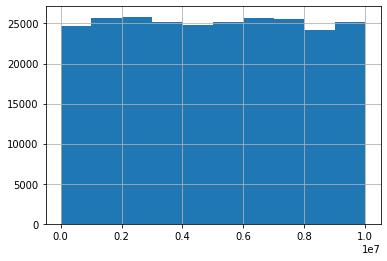

In [ ]:
df['Income'].hist()

In [ ]:
## Identify the 25th percentile
df['Income'].describe().apply(lambda x: format(x, 'f'))

count     252000.000000
mean     4997116.665325
std      2878311.013611
min        10310.000000
25%      2503015.000000
50%      5000694.500000
75%      7477502.000000
max      9999938.000000
Name: Income, dtype: object

In [ ]:
# Convert Income into a binary column by separating those with income above and below the 25th percentile
def change_income(income):
  if income <= 2503015.000000:
    return 1
  return 0

df['binary_income'] = df['Income'].apply(change_income)

df.value_counts("binary_income")

binary_income
0    188999
1     63001
dtype: int64

In [ ]:
df.head()

,Id,Income,Age,Experience,Married/Single,House_Ownership,Car_Ownership,Profession,CITY,STATE,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,Risk_Flag,binary_income
0,1,1303834,23,3,1,0,0,33,251,13,3,13,0,1
1,2,7574516,40,10,1,0,0,43,227,14,9,13,0,0
2,3,3991815,66,4,0,0,0,47,8,12,4,10,0,0
3,4,6256451,41,2,1,0,1,43,54,17,2,12,1,0
4,5,5768871,47,11,1,0,0,11,296,22,3,14,1,0


## Step 1: Model Causal Mechanism

In [ ]:
# Build the causal DAG.
dot = graphviz.Digraph()

dot.node('Age', 'Age')
dot.node('Married/Single', 'Married/Single')
dot.node('House_Ownership', 'House_Ownership')
dot.node('CURRENT_JOB_YRS', 'CURRENT_JOB_YRS')
dot.node('Experience', 'Experience')
dot.node('binary_income', 'binary_income')
dot.node('House_Ownership', 'House_Ownership')
dot.node('Profession', 'Profession')
dot.node('CITY', 'CITY')
dot.node('Car_Ownership', 'Car_Ownership')
dot.node('CURRENT_HOUSE_YRS', 'CURRENT_HOUSE_YRS')
dot.node('Risk_Flag', 'Risk_Flag')

dot.edge('Age','Married/Single')
dot.edge('Married/Single','House_Ownership')
dot.edge('Age','CURRENT_JOB_YRS')
dot.edge('CURRENT_JOB_YRS','Experience')
dot.edge('Experience','binary_income')
dot.edge('binary_income','House_Ownership')
dot.edge('Profession','binary_income')
dot.edge('CITY', 'Profession')
dot.edge('CITY', 'Car_Ownership')
dot.edge('CITY', 'House_Ownership')
dot.edge('Income', 'Car_Ownership')
dot.edge('House_Ownership', 'CURRENT_HOUSE_YRS')
dot.edge('binary_income', 'Risk_Flag')
dot.edge('CITY', 'Risk_Flag')
    
print(dot.source)

digraph {
	Age [label=Age]
	"Married/Single" [label="Married/Single"]
	House_Ownership [label=House_Ownership]
	CURRENT_JOB_YRS [label=CURRENT_JOB_YRS]
	Experience [label=Experience]
	binary_income [label=binary_income]
	House_Ownership [label=House_Ownership]
	Profession [label=Profession]
	CITY [label=CITY]
	Car_Ownership [label=Car_Ownership]
	CURRENT_HOUSE_YRS [label=CURRENT_HOUSE_YRS]
	Risk_Flag [label=Risk_Flag]
	Age -> "Married/Single"
	"Married/Single" -> House_Ownership
	Age -> CURRENT_JOB_YRS
	CURRENT_JOB_YRS -> Experience
	Experience -> binary_income
	binary_income -> House_Ownership
	Profession -> binary_income
	CITY -> Profession
	CITY -> Car_Ownership
	CITY -> House_Ownership
	Income -> Car_Ownership
	House_Ownership -> CURRENT_HOUSE_YRS
	binary_income -> Risk_Flag
	CITY -> Risk_Flag
}


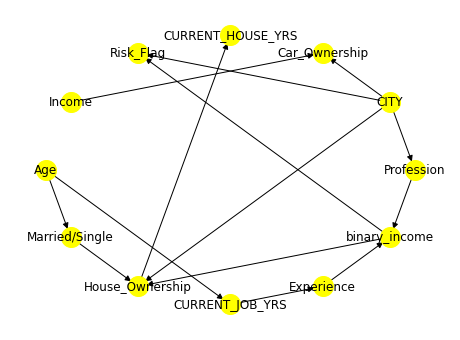

In [ ]:
# I. Create a causal model from the data and domain knowledge.
model = CausalModel(
    data=df,
    graph = dot.source.replace("\t", " ").replace("\n", ' '),
    treatment=['binary_income'],
    outcome=["Risk_Flag"],
    common_causes=["CITY"],
    # Should age be the instrument as it is the direct cause of marital status?
    # How do we account for the mediator of years in current house?
    instruments =['Profession', 'Experience'])
model.view_model()

The above Causal DAG is identical to the DAG we defined in our previous analysis, however, we have now replaced income with the binary income variable and use that as our treatment.

## Step 2: Identify the Target Estimand

In [ ]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
       d                                           
────────────────(Expectation(Risk_Flag|Profession))
d[binary_income]                                   
Estimand assumption 1, Unconfoundedness: If U→{binary_income} and U→Risk_Flag then P(Risk_Flag|binary_income,Profession,U) = P(Risk_Flag|binary_income,Profession)

### Estimand : 2
Estimand name: iv
Estimand expression:
Expectation(Derivative(Risk_Flag, [Experience])*Derivative([binary_income], [E
xperience])**(-1))
Estimand assumption 1, As-if-random: If U→→Risk_Flag then ¬(U →→{Experience})
Estimand assumption 2, Exclusion: If we remove {Experience}→{binary_income}, then ¬({Experience}→Risk_Flag)

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



Similar to our analysis with income as a continous variable, 2 estimands were found given the data and the causal DAG. This suggests that a causal effect can be estimated. The first estimand indicates that we can use the Backdoor criterion to estimate the causal effect. Assuming all common causes are identified, we can condition on them to estimate the effect. The second estimand is Instrumental Variable identification which relies on splitting up the effect of the instrument on the treatment and the treatment and the action to measure the effect of the treatment on the outcome. Similar to the previous analysis, we can use experience as our instrumental variable for the second estimand to estimate the causal effect. Lastly, the third estimand is based on the frontdoor criterion. As there is no mediator between income and risk of default, an estimand through the frontdoor criterion cannot be found.

## Step 3: Estimate the Causal Effect Using Statistical Estimators

1. Linear Regression

In this approach, a linear regression model is fit over the treatment and the common causes to target the backdoor estimand. The resulting coefficient of our treatment represents the estimate of the causal effect. As the Causal effect estimate is within the 95% confidence interval, we cannot reject the null hypothesis that the true value of the coefficient is 0. This suggests a causal effect may not exist.

In [ ]:
causal_estimate_reg = model.estimate_effect(identified_estimand,
        method_name="backdoor.linear_regression",
        confidence_intervals=True)

print(causal_estimate_reg)
print("The causal effect estimate is " + str(round(causal_estimate_reg.value, 4)))

linear_regression
{'control_value': 0, 'treatment_value': 1, 'test_significance': None, 'evaluate_effect_strength': False, 'confidence_intervals': True, 'target_units': 'ate', 'effect_modifiers': []}
*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
       d                                           
────────────────(Expectation(Risk_Flag|Profession))
d[binary_income]                                   
Estimand assumption 1, Unconfoundedness: If U→{binary_income} and U→Risk_Flag then P(Risk_Flag|binary_income,Profession,U) = P(Risk_Flag|binary_income,Profession)

## Realized estimand
b: Risk_Flag~binary_income+Profession
Target units: ate

## Estimate
Mean value: 0.0065732929204740664
95.0% confidence interval: [[0.00361198 0.0095346 ]]

The causal effect estimate is 0.0066


2. Propensity Score Stratification

Propensity score stratification was applied where subsets of the data are taken according to propensity scores and a weighted average estimate of the outcome given the treatment is computed. The Average treatment effect computed by propensity score stratification is within the 95% confidence interval, although the estimated effect is minimal.

In [ ]:
causal_estimate_strat = model.estimate_effect(identified_estimand,
                                              method_name="backdoor.propensity_score_stratification",
                                              target_units="ate",
                                              confidence_intervals=True)
print(causal_estimate_strat)
print("The causal effect estimate is " + str(round(causal_estimate_strat.value, 4)))

propensity_score_stratification
*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
       d                                           
────────────────(Expectation(Risk_Flag|Profession))
d[binary_income]                                   
Estimand assumption 1, Unconfoundedness: If U→{binary_income} and U→Risk_Flag then P(Risk_Flag|binary_income,Profession,U) = P(Risk_Flag|binary_income,Profession)

## Realized estimand
b: Risk_Flag~binary_income+Profession
Target units: ate

## Estimate
Mean value: 0.006692279377266745
95.0% confidence interval: (0.003769595537200616, 0.009261564298707878)

The causal effect estimate is 0.0067


3. Propensity Score Matching

Similarly, propensity score matching was also attempted, but was not completed due to the method not being implemented in DoWhy

In [ ]:
causal_estimate_match = model.estimate_effect(identified_estimand,
                                              method_name="backdoor.propensity_score_matching",
                                              target_units="ate",
                                              confidence_intervals=True)
print(causal_estimate_match)
print("The causal effect estimate is " + str(round(causal_estimate_match.value, 4)))

propensity_score_matching


KeyboardInterrupt: ignored

4. Propensity Score Weighting

Propensity Score Weighting uses inverse probability weighting to avoid bias in group sizes where treatment is received or not. Using propensity score weighting, the average treatment effect is within the confidence interval, although the causal effect estimate is very small.

In [ ]:
causal_estimate_ipw = model.estimate_effect(identified_estimand,
                                            method_name="backdoor.propensity_score_weighting",
                                            target_units = "ate",
                                            method_params={"weighting_scheme":"ips_weight"},
                                            confidence_intervals=True)
print(causal_estimate_ipw)
print("The causal effect estimate is " + str(round(causal_estimate_ipw.value, 4)))

propensity_score_weighting
*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
       d                                           
────────────────(Expectation(Risk_Flag|Profession))
d[binary_income]                                   
Estimand assumption 1, Unconfoundedness: If U→{binary_income} and U→Risk_Flag then P(Risk_Flag|binary_income,Profession,U) = P(Risk_Flag|binary_income,Profession)

## Realized estimand
b: Risk_Flag~binary_income+Profession
Target units: ate

## Estimate
Mean value: 0.006572743602509423
95.0% confidence interval: (0.00429993285086476, 0.009045283489510628)

The causal effect estimate is 0.0066


5. Wald Estimator

To address the second estimand, the Wald estimator was used with Experience as the instrumental variable. The Wald estimator attempts to provide an estimate without relying on any of the common causes. The Wald estimator produces an estimate that is within the 95% confidence interval which suggests that we cannot reject the null hypothesis. As the null hypothesis is not rejected, it suggests that there may be exogeneity present, meaning that we cannot doubt that causality exists.

In [ ]:
causal_estimate_iv = model.estimate_effect(identified_estimand,
        method_name="iv.instrumental_variable",
        method_params = {'iv_instrument_name': 'Experience'},
        confidence_intervals=True
)
print(causal_estimate_iv)
print("The causal effect estimate is " + str(round(causal_estimate_iv.value, 4)))

instrumental_variable
*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: iv
Estimand expression:
Expectation(Derivative(Risk_Flag, [Experience])*Derivative([binary_income], [E
xperience])**(-1))
Estimand assumption 1, As-if-random: If U→→Risk_Flag then ¬(U →→{Experience})
Estimand assumption 2, Exclusion: If we remove {Experience}→{binary_income}, then ¬({Experience}→Risk_Flag)

## Realized estimand
Realized estimand: Wald Estimator
Realized estimand type: nonparametric-ate
Estimand expression:
                                                                              
Expectation(Derivative(Risk_Flag, Experience))⋅Expectation(Derivative(binary_i

                   -1
ncome, Experience))  
Estimand assumption 1, As-if-random: If U→→Risk_Flag then ¬(U →→{Experience})
Estimand assumption 2, Exclusion: If we remove {Experience}→{binary_income}, then ¬({Experience}→Risk_Flag)
Estimand assumption 3, treatment_effect_homogene

6. Distance Matching

Distance Matching was also attempted but resulted in an error, even after our treatment being converted to a binary variable.

In [ ]:
causal_estimate_dmatch = model.estimate_effect(identified_estimand,
                                              method_name="backdoor.distance_matching",
                                              target_units="att",
                                              method_params={'distance_metric':"minkowski", 'p':2})
print(causal_estimate_dmatch)
print("The causal effect estimate is " + str(round(causal_estimate_dmatch.value,4)))

distance_matching


Exception: ignored

## Step 4: Refute Estimate

### Step 1: Refute Linear Regression Estimate

**Add Random Common Cause**

Refutation of an uncorrelated confounder was attempted. The results suggest that our model estimates are robust to uncorrelated confounders as the new estimate and the estimated effect are very close. Adding a random common cause does not appear to change the estimate.

In [ ]:
res_random = model.refute_estimate(identified_estimand, causal_estimate_reg,
                                   method_name="random_common_cause", num_simulations=10)
print(res_random)

{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': True, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': True, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': True, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': True, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': True, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effe

**Add Unobserved Common Cause**

We show below how robust our estimate is to unobserved confounders. Relatively, the difference betweent the two estimates is large which indicates our results may not be robust to an unobserved confounder.

In [ ]:
res_unobserved = model.refute_estimate(identified_estimand, causal_estimate_reg,
                                       method_name="add_unobserved_common_cause",
                                       confounders_effect_on_treatment="binary_flip", confounders_effect_on_outcome="linear",
                                       effect_strength_on_treatment=0.05, effect_strength_on_outcome=0.5)
print(res_unobserved)

{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': True, 'target_units': 'ate', 'effect_modifiers': []}
Refute: Add an Unobserved Common Cause
Estimated effect:0.0065732929204740664
New effect:-0.12835834906411533



**Remove a Random Subset of the Data**

We test below whether we observe a similar estimate on a subset of the data. The estimated effect and new effect are very close and the p-value is greater than 0.05. Therefore, we cannot reject the null hypothesis that the estimated effect is under the average treatment effect distribution.

In [ ]:
res_subset = model.refute_estimate(identified_estimand, causal_estimate_reg,
                                  method_name="data_subset_refuter", subset_fraction=0.8, 
                                    num_simulations=2)
print(res_subset)

{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': True, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': True, 'target_units': 'ate', 'effect_modifiers': []}
Refute: Use a subset of data
Estimated effect:0.0065732929204740664
New effect:0.006349409981613707
p value:0.0029814065995896755



**Replace Treatment with a Random (Placebo) Variable**

We also observed the impact of replacing the treatment variable with noise. The results show that the new effect does not approach 0 which means there may be instability in our estimate. However, as the p-value is greater than 0.05, we cannot reject the null hypothesis that 0 is under the average treatment effect distribution.

In [ ]:
res_placebo=model.refute_estimate(identified_estimand, causal_estimate_reg,
        method_name="placebo_treatment_refuter", placebo_type="permute",
        num_simulations=20)
print(res_placebo)

{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': True, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': True, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': True, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': True, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': True, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effe

### Step 2: Refute Propensity Score Stratification estimate

**Add Random Common Cause**

Refutation of an uncorrelated confounder was attempted, however, this method is not yet implemented in DoWhy.

In [ ]:
res_random = model.refute_estimate(identified_estimand, causal_estimate_strat,
                                   method_name="random_common_cause", num_simulations=10)
print(res_random)

KeyboardInterrupt: ignored

**Add Unobserved Common Cause**

We show below how robust our estimate is to unobserved confounders. Relatively, the difference betweent the two estimates is large which indicates our results may not be robust to an unobserved confounder.

In [ ]:
res_unobserved = model.refute_estimate(identified_estimand, causal_estimate_strat,
                                       method_name="add_unobserved_common_cause",
                                       confounders_effect_on_treatment="binary_flip", confounders_effect_on_outcome="linear",
                                       effect_strength_on_treatment=0.05, effect_strength_on_outcome=0.5)
print(res_unobserved)

Refute: Add an Unobserved Common Cause
Estimated effect:0.006692279377266745
New effect:-0.12377925729066339



**Remove a Random Subset of the Data**

We test below whether we observe a similar estimate on a subset of the data. The estimated effect and new effect are very close and the p-value is greater than 0.05. Therefore, we cannot reject the null hypothesis that the estimated effect is under the average treatment effect distribution.

In [ ]:
res_subset = model.refute_estimate(identified_estimand, causal_estimate_reg,
                                  method_name="data_subset_refuter", subset_fraction=0.8, 
                                    num_simulations=2)
print(res_subset)

{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': True, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': True, 'target_units': 'ate', 'effect_modifiers': []}
Refute: Use a subset of data
Estimated effect:0.0065732929204740664
New effect:0.006580970231241837
p value:0.49758618420952067



**Replace Treatment with a Random (Placebo) Variable**

We also observed the impact of replacing the treatment variable with noise. The results show that the new effect approaches 0 which means our results are robust to a random treatment variable. Additionally, as the p-value is greater than 0.05, which means we cannot reject the null hypothesis that 0 is under the average treatment effect distribution.

In [ ]:
res_placebo=model.refute_estimate(identified_estimand, causal_estimate_reg,
        method_name="placebo_treatment_refuter", placebo_type="permute",
        num_simulations=20)
print(res_placebo)

{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': True, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': True, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': True, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': True, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': True, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effe

### Step 3: Refute Propensity Score Weighting Estimate

**Add Random Common Cause**

Refutation of an uncorrelated confounder was performed. The results suggest that our model estimates are robust to uncorrelated confounders as the new estimate and the estimated effect are very close. Adding a random common cause does not appear to change the estimate.

In [ ]:
res_random = model.refute_estimate(identified_estimand, causal_estimate_ipw,
                                   method_name="random_common_cause", num_simulations=10)
print(res_random)


Refute: Add a random common cause
Estimated effect:0.006572743602509423
New effect:0.006570649400844108
p value:0.3082253718587744



**Add Unobserved Common Cause**

We show below how robust our estimate is to unobserved confounders. Relatively, the difference betweent the two estimates is large which indicates our results may not be robust to an unobserved confounder.

In [ ]:
res_unobserved = model.refute_estimate(identified_estimand, causal_estimate_ipw,
                                       method_name="add_unobserved_common_cause",
                                       confounders_effect_on_treatment="binary_flip", confounders_effect_on_outcome="linear",
                                       effect_strength_on_treatment=0.05, effect_strength_on_outcome=0.5)
print(res_unobserved)

Refute: Add an Unobserved Common Cause
Estimated effect:0.006572743602509423
New effect:-0.12796900316324486



**Remove a Random Subset of the Data**

We test below whether we observe a similar estimate on a subset of the data. The estimated effect and new effect are very close and the p-value is greater than 0.05. Therefore, we cannot reject the null hypothesis that the estimated effect is under the average treatment effect distribution.

In [ ]:
res_subset = model.refute_estimate(identified_estimand, causal_estimate_ipw,
                                  method_name="data_subset_refuter", subset_fraction=0.8, 
                                    num_simulations=2)
print(res_subset)

Refute: Use a subset of data
Estimated effect:0.006572743602509423
New effect:0.006760559978749955
p value:0.4022145925808181



**Replace Treatment with a Random (Placebo) Variable**

We also attempted to observe the impact of replacing the treatment variable with noise. However, this refutation analysis is not yet implemented in DoWhy

In [ ]:
res_placebo=model.refute_estimate(identified_estimand, causal_estimate_ipw,
        method_name="placebo_treatment_refuter", placebo_type="permute",
        num_simulations=20)
print(res_placebo)

KeyboardInterrupt: ignored

### Step 4. Refute Wald Estimator estimate

**Add Random Common Cause**

Refutation of an uncorrelated confounder was performed by adding a random common cause. The results suggest that our model estimates are robust to uncorrelated confounders as the new estimate and the estimated effect are very close. Adding a random common cause does not appear to change the estimate.

In [ ]:
res_random = model.refute_estimate(identified_estimand, causal_estimate_iv,
                                   method_name="random_common_cause", num_simulations=10)
print(res_random)

Refute: Add a random common cause
Estimated effect:4.201062896979632
New effect:4.201062896979633
p value:0.15865525393145707



**Add Unobserved Common Cause**

We show below how robust our estimate is to unobserved confounders. As the difference between the two estimates is large, it indicates our results are not robust to an unobserved confounder.

In [ ]:
res_unobserved = model.refute_estimate(identified_estimand, causal_estimate_iv,
                                       method_name="add_unobserved_common_cause",
                                       confounders_effect_on_treatment="binary_flip", confounders_effect_on_outcome="linear",
                                       effect_strength_on_treatment=0.05, effect_strength_on_outcome=0.5)
print(res_unobserved)

Refute: Add an Unobserved Common Cause
Estimated effect:4.201062896979632
New effect:5.333941158361606



In [ ]:
res_subset = model.refute_estimate(identified_estimand, causal_estimate_iv,
                                  method_name="data_subset_refuter", subset_fraction=0.8, 
                                    num_simulations=2)
print(res_subset)

Refute: Use a subset of data
Estimated effect:4.201062896979632
New effect:4.0690378799264515
p value:0.33224570422452715



**Replace Treatment with a Random (Placebo) Variable**

We also observed the impact of replacing the treatment variable with noise. The results show that the new effect does not approach 0, therefore our results are not robust to a random variable. However, as the p-value is greater than 0.05, which means we cannot reject the null hypothesis that 0 is under the average treatment effect distribution.

In [ ]:
res_placebo=model.refute_estimate(identified_estimand, causal_estimate_iv,
        method_name="placebo_treatment_refuter", placebo_type="permute",
        num_simulations=20)
print(res_placebo)

Refute: Use a Placebo Treatment
Estimated effect:4.201062896979632
New effect:-78.26525252159534
p value:0.414160783695257



In conclusion, we do not have enough clarity to assume that the causal effect exists. While most of our refutation tests passed on all the statistical methods attempted, each estimator explored was not robust to an unobserved confounder. Therefore, we cannot conclude the causal estimates exists.

# Directional DoubleML Analysis: Loan Defaults on Home Ownership

Based on an analysis of 401k data found here: https://github.com/py-why/dowhy/blob/main/docs/source/example_notebooks/gcm_401k_analysis.ipynb

In [ ]:
df = cleanData(pd.read_csv('Training Data.csv'))
df.head()


numeric columns:  ['Id', 'Income', 'Age', 'Experience', 'CURRENT_JOB_YRS', 'CURRENT_HOUSE_YRS', 'Risk_Flag']

categorical columns:  ['Married/Single', 'House_Ownership', 'Car_Ownership', 'Profession', 'CITY', 'STATE']


,Id,Income,Age,Experience,Married/Single,House_Ownership,Car_Ownership,Profession,CITY,STATE,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,Risk_Flag
0,1,1303834,23,3,1,2,0,33,251,13,3,13,0
1,2,7574516,40,10,1,2,0,43,227,14,9,13,0
2,3,3991815,66,4,0,2,0,47,8,12,4,10,0
3,4,6256451,41,2,1,2,1,43,54,17,2,12,1
4,5,5768871,47,11,1,2,0,11,296,22,3,14,1


In [ ]:
# treatment is Loan Default status
treatment_var = "Risk_Flag"
# outcome is Income
outcome_var = "House_Ownership"

# Remove treatment/outcome from list of all columns
headers = [h for h in df.columns]
headers.remove('Risk_Flag')
headers.remove('House_Ownership')
# Use this as list of covariates
covariates = headers

# draw edges assuming no interactions between covariates (may want to further study/model)
edges = [(treatment_var, outcome_var)]
edges.extend([(covariate, treatment_var) for covariate in covariates])
edges.extend([(covariate, outcome_var) for covariate in covariates])

causal_graph = nx.DiGraph(edges)

## Simplified DAG - no interactions
Here we create a simplified graph where there are no interactions between covariates. This is an oversimplication of the domain, however, as we take joint samples of the covariates—directly from the observed data—later to estimate CATEs, we can ignore their interactions.

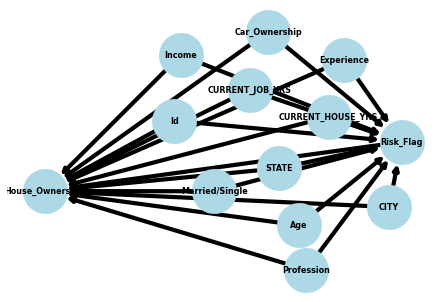

In [ ]:
gcm.util.plot(causal_graph)

We plot their histograms to view the distributions of the variables.

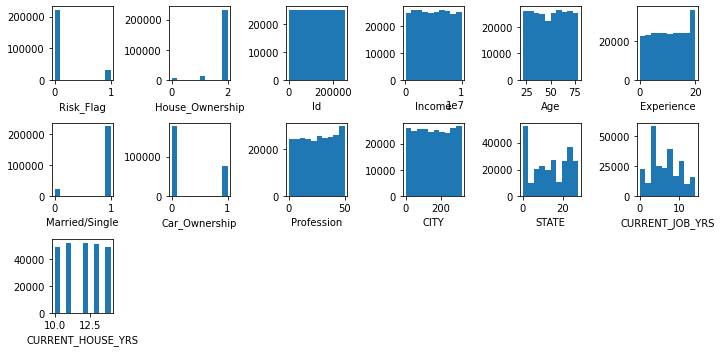

In [ ]:
cols = [treatment_var, outcome_var]
cols.extend(covariates)
plt.figure(figsize=(10,5))
for i, col in enumerate(cols):
    plt.subplot(3,6,i+1)
    plt.grid(False)
    plt.hist(df[col])
    plt.xlabel(col)
plt.tight_layout()
plt.show()

## DoubleML
We next assign causal models to variables. For the treatment variable, we assign a classifier functional causal model (FCM) with a random forest classifier. For the outcome variable, we assign an additive noise model with a random forest classifer as a function and empirical distribution for the noise. We assign empirical distributions to other variables as they do not have parents in the causal graph."

In [ ]:
causal_model = gcm.StructuralCausalModel(causal_graph)
causal_model.set_causal_mechanism(treatment_var, gcm.ClassifierFCM(gcm.ml.create_random_forest_classifier()))
causal_model.set_causal_mechanism(outcome_var, gcm.AdditiveNoiseModel(gcm.ml.create_random_forest_classifier()))
for covariate in covariates:
    causal_model.set_causal_mechanism(covariate, gcm.EmpiricalDistribution())

We now fit the learn the causal models from our data stored in our dataframe.

In [ ]:
df = df.astype({treatment_var: str})
gcm.fit(causal_model, df)

Fitting causal mechanism of node CURRENT_HOUSE_YRS: 100%|██████████| 13/13 [01:49<00:00,  8.39s/it]


## Observing Treatment Effect by Income
Before we compute the Conditional Average Treatment Effect (CATE), we want to first divide individuals into bins of income percentiles so that we can better measure the effect across income groups.

In [ ]:
percentages = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
bin_edges = [0]
bin_edges.extend(np.quantile(df.Income, percentages[1:]).tolist())
bin_edges[-1] += 1 # adding 1 to the last edge as last edge is excluded by np.digitize

groups = [f'{percentages[i]*100:.0f}%-{percentages[i+1]*100:.0f}%' for i in range(len(percentages)-1)]
group_index_to_group_label = dict(zip(range(1, len(bin_edges)+1), groups))

Finally, we compute CATE. We perform a randomised intervention on the treatment variable in the fitted causal graph, draw samples from the interventional distribution, group observations by the income group, and then compute the treatment effect in each group.

In [ ]:
def estimate_cate():
    samples = gcm.interventional_samples(causal_model, 
                                         {treatment_var: lambda x: np.random.choice(['0', '1'])},
                                         observed_data=df)
    eligible = samples[treatment_var] == '1'
    ate = samples[eligible][outcome_var].mean() - samples[~eligible][outcome_var].mean()
    result = dict(ate = ate)
    
    group_indices = np.digitize(samples['Income'], bin_edges)
    samples['group_index'] = group_indices
    
    for group_index in group_index_to_group_label:
        group_samples = samples[samples['group_index'] == group_index]
        eligible_in_group = group_samples[treatment_var] == '1'
        cate = group_samples[eligible_in_group][outcome_var].mean() - group_samples[~eligible_in_group][outcome_var].mean()
        result[group_index_to_group_label[group_index]] = cate
        
    return result

group_to_median, group_to_ci = gcm.confidence_intervals(estimate_cate, num_bootstrap_resamples=100)
print(group_to_median)
print(group_to_ci)

Estimating boostrap interval...: 100%|██████████| 100/100 [25:42<00:00, 15.42s/it]

{'ate': 0.08077711092479169, '0%-20%': 0.07736815378409814, '20%-40%': 0.09069469314427225, '40%-60%': 0.0817468825377929, '60%-80%': 0.08036084735562543, '80%-100%': 0.07373021007346356}
{'ate': array([0.07912396, 0.08228953]), '0%-20%': array([0.072848  , 0.08116971]), '20%-40%': array([0.0877631 , 0.09442272]), '40%-60%': array([0.0783945 , 0.08537639]), '60%-80%': array([0.07754247, 0.08379782]), '80%-100%': array([0.07019024, 0.07654231])}


The average treatment effect of a Loan Default on Home Ownership is is positive and follows an interesting normal pattern with a right skew. We continue to plot CATEs of various income groups to see if we can discern any trends.

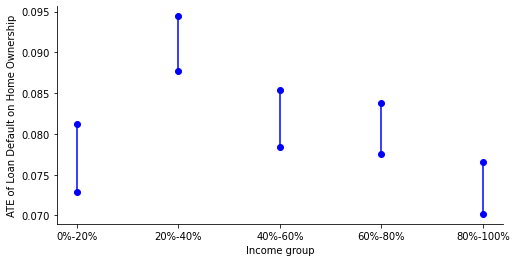

In [ ]:
fig = plt.figure(figsize=(8,4))
for x, group in enumerate(groups):
    ci = group_to_ci[group]
    plt.plot((x, x), (ci[0], ci[1]), 'ro-', color='blue')
ax = fig.axes[0]
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xticks(range(len(groups)), groups)
plt.xlabel('Income group')
plt.ylabel('ATE of Loan Default on Home Ownership')
plt.show()

The impact follows a normal curve with a right skew. Loan defaults affect those with very high or low income more so than those with middle amounts of income in regards to owning a home. This trend, while at first seems odd, actually may be intuitive. Low income individuals may not own a home at all, so defaulting on a loan would not have an effect on home ownership. High income individuals who default on a loan may have excess income such that their home ownership is unaffected. We see a generally decreasing trend from 20% on, meaning that the more income the individual has the less affected they are by a loan default. This suggests that defaulting on a loan can be quite crippling for those with lower incomes.

# Directional DoubleML Analysis: Analysis of Loan Defaults on Car Ownership

We repeat our analysis of Defaulting on Loans to Car Ownership and observe treatment effect sizes by Income Group

In [ ]:
# treatment is Loan Default status
treatment_var = "Risk_Flag"
# outcome is Income
outcome_var = "Car_Ownership"

# Remove treatment/outcome from list of all columns
headers = [h for h in df.columns]
headers.remove('Risk_Flag')
headers.remove('Car_Ownership')
# Use this as list of covariates
covariates = headers

# draw edges assuming no interactions between covariates (may want to further study/model)
edges = [(treatment_var, outcome_var)]
edges.extend([(covariate, treatment_var) for covariate in covariates])
edges.extend([(covariate, outcome_var) for covariate in covariates])

causal_graph = nx.DiGraph(edges)

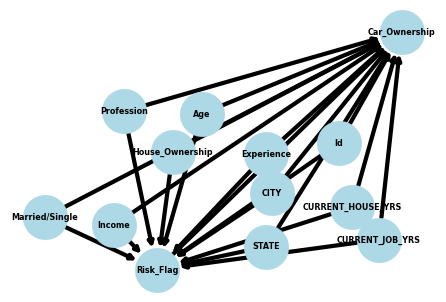

In [ ]:
gcm.util.plot(causal_graph)

In [ ]:
causal_model = gcm.StructuralCausalModel(causal_graph)
causal_model.set_causal_mechanism(treatment_var, gcm.ClassifierFCM(gcm.ml.create_random_forest_classifier()))
causal_model.set_causal_mechanism(outcome_var, gcm.AdditiveNoiseModel(gcm.ml.create_random_forest_regressor()))
for covariate in covariates:
    causal_model.set_causal_mechanism(covariate, gcm.EmpiricalDistribution())

In [ ]:
df = df.astype({treatment_var: str})
gcm.fit(causal_model, df)

Fitting causal mechanism of node CURRENT_HOUSE_YRS: 100%|██████████| 13/13 [03:26<00:00, 15.86s/it]


In [ ]:
percentages = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
bin_edges = [0]
bin_edges.extend(np.quantile(df.Income, percentages[1:]).tolist())
bin_edges[-1] += 1 # adding 1 to the last edge as last edge is excluded by np.digitize

groups = [f'{percentages[i]*100:.0f}%-{percentages[i+1]*100:.0f}%' for i in range(len(percentages)-1)]
group_index_to_group_label = dict(zip(range(1, len(bin_edges)+1), groups))

In [ ]:
group_to_median, group_to_ci = gcm.confidence_intervals(estimate_cate, num_bootstrap_resamples=100)
print(group_to_median)
print(group_to_ci)

Estimating boostrap interval...: 100%|██████████| 100/100 [25:01<00:00, 15.02s/it]

{'ate': -0.0006303148687123611, '0%-20%': 0.01071760083332949, '20%-40%': 0.003125701219785217, '40%-60%': -0.012183280419831594, '60%-80%': -0.0043836347465622495, '80%-100%': -0.0004384564328515077}
{'ate': array([-0.0023152 ,  0.00121051]), '0%-20%': array([0.00563939, 0.01565912]), '20%-40%': array([-0.0022028 ,  0.00860492]), '40%-60%': array([-0.01662734, -0.00599695]), '60%-80%': array([-0.01005852,  0.00150673]), '80%-100%': array([-0.00500959,  0.00443907])}


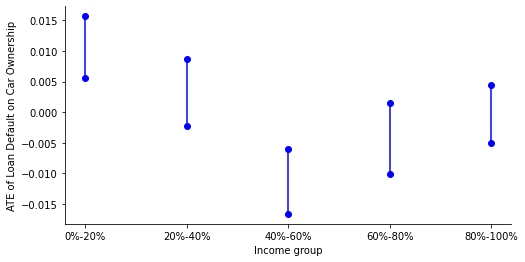

In [ ]:
fig = plt.figure(figsize=(8,4))
for x, group in enumerate(groups):
    ci = group_to_ci[group]
    plt.plot((x, x), (ci[0], ci[1]), 'ro-', color='blue')
ax = fig.axes[0]
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xticks(range(len(groups)), groups)
plt.xlabel('Income group')
plt.ylabel('ATE of Loan Default on Car Ownership')
plt.show()

This time the observed effect is likely not significant, as the confidence intervals for ATE straddles 0. We interestingly see the a U shaped effect as one moves from lower to higher income groups. Loan defaults affect those with lower and higher income more so than those with higher income in regards to owning a car. A possible explanation may be that those in low and high incomes tend to buy expensive cars relative to their incomes using loans, whereas the middle income brackets may buy vehicles within their means. Another possible explanation may be that low income and high income individuals have most of their debt in the form of either auto or home loans, respectively. Defaulting on such a loan would affect car ownership, as this may be a likely asset to first be affected by a loan default.

# Converting to PDF, HTML, and Downloading Notebook

In [ ]:
from google.colab import files
from google.colab import drive

In [ ]:
%%capture
!sudo dpkg --configure -a
!sudo apt-get update
!sudo apt-get install texlive-xetex texlive-fonts-recommended texlive-generic-recommended
!apt-get install texlive texlive-xetex texlive-latex-extra pandoc
!pip install pypandoc

In [ ]:
%%capture
drive.mount('/content/drive')
!cp drive/My\ Drive/Colab\ Notebooks/CausalEffectsLoanDefaults_v3.ipynb ./
!jupyter nbconvert --to pdf "CausalEffectsLoanDefaults_v3.ipynb"
!jupyter nbconvert --to html "CausalEffectsLoanDefaults_v3.ipynb"

In [ ]:
from google.colab import files
files.download('CausalEffectsLoanDefaults_v3.ipynb')
files.download('CausalEffectsLoanDefaults_v3.pdf')
files.download('CausalEffectsLoanDefaults_v3.html')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>